In [1]:
import numpy as np
import numpy.fft as ft
import matplotlib.pyplot as plt
import timeit as tm

In [2]:
# Función que define el filtro, el cual tiene una frecuencia de corte normalizada igual a 0.25 o pi/4  o fs/8.
def IdealLPF(wc,L):
    n = np.arange(0,L+1)
    h = wc*np.sinc(wc*(n-(L/2)))
    return h;

# FUNCIÓN DE FILTRADO CON FFT (Subconjuntos: OLA y OLS).
# Esta función se usará tanto para OLA como OLS, la diferencia está en cómo se construye el bloque de 
# entrada y cómo se construye el bloque de salida.
# Es el filtrado de las frecuencias... la long de la FFT es H, el H está precalculado.
def FIR_FFT(x,H): 
    y = np.real(ft.ifft(ft.fft(x,len(H))*H))
    return y;

In [3]:
# Parámtros del filtro.

N = 56 #Filter order, el número de muestras del filtro es 57... 
# NOTAS: Si no se de qué longitud es mi filtro, tampoco se de qué long. serán los buff.. y tampoco podría 
# definir la long. de la FFT... Se debe definir la long. del filtro previamente, considerando que:
# IMPORTANTE: que la long. del filtro sea tal que muestree en la meceta hasta la frec. de corte, porque si de 56 cambio
# a 10, particularmente en este ejemplo, ya no muestreo hasta 0.25, sino hasta menos. HAY QUE REVISAR ESTO, para darle
# al filtro una long. ideal.

wc = 0.25 #Cutoff frequency, es el filtro paso bajo, elimina las freq que estén por encima de la freq
# de corte... y deja pasar las que estén por debajo de esa freq.
# freq límite es 0.25 es una freq discreta normalizada, la no normalizada tiene su eje x de 
# -pi a - pi, o de -fs/2 a fs/2, la normalizada va de -1 a 1, la freq discreta norm es la que comunmente
# se usa para el diseño de filtros digitales.
# En este caso 0.25 equivale a pi/4 o fs/8.

# Parámetros del Buffer.
M = 200 #Input buffer, aplica solo a OLA y OLS. Tamaño de los bloques en los que voy a dividir mi señal
# de entrada. Se elige un valor que sumado a N, sea igual a una potencia de 2.
L = N + M #FFT size

buff_OLA = np.zeros((N,)) #Buffer for FIR_FFT

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_13048/2873267467.py:21: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(2)


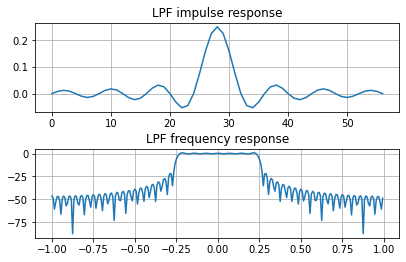

In [4]:
#Get an impulse response for testing

filt = IdealLPF(wc,N) # Este es el filtro paso bajo ó h[n], filtros paso bajo reales tienen como 
# respuesta al impulso la función sinc, que tiene como parámetros la freq de corte y el orden. Filtro en
# el tiempo.

filt_f = ft.fft(filt,L) # Es el H, la respuesta en frecuencia, se calcula con longitud L, que es N+M o la misma 
# long. de la FFT y este es el que se usa con OLA. Filtro en la frecuencia.

w = ft.fftshift(ft.fftfreq(filt_f.size,1/2)) # Véctor de frecuencias del filtro.

mag_filt_f = 20*np.log10(np.abs(ft.fftshift(filt_f))) # Véctor de magnitudes del filtro. 

plt.figure()
plt.subplot(2,1,1)
plt.plot(filt)
plt.title('LPF impulse response')
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(w,mag_filt_f)
plt.tight_layout(2)
plt.title('LPF frequency response')
plt.grid(True)

In [12]:
#Create a test signal

f1 = 750
f2 = 7000
fs = 16000
t = np.arange(0,16000)*(1/fs) # en segundos.
# print(t)
# print(len(t))
test = 0.5*np.cos(2*np.pi*f1*t) + 0.5*np.cos(2*np.pi*f2*t)
# print(len(test))
test_f = ft.fftshift(ft.fft(test))
# print(len(test_f))
w = ft.fftshift(ft.fftfreq(test_f.size,1/2))
# print(len(w))


In [6]:
# plt.plot(t,test)
# plt.title('Input signal (time domain)')

In [10]:
#FIR FFT filtering (OLA)

# El bloque de entrada de la señal es test[i:i+M-1] 
# El filtro es filt_f que es la FFT de h[n] o sea H.
   
y_ola = np.zeros(test.size)
tic = tm.default_timer()
for i in np.arange(0,len(test),M):
    buf = FIR_FFT(test[i:i+M],filt_f)
    y_ola[i:i+M] = buf[0:M]
    y_ola[i:i+N] = y_ola[i:i+N] + buff_OLA
    buff_OLA = buf[M:]
toc = tm.default_timer()
#Approx. filtering time
print(toc-tic)
y_ola_f = ft.fftshift(ft.fft(y_ola))
mag_y_ola_f = np.abs(y_ola_f)

# y_ola es la señal completa filtrada, después de que se ha procesado bloque por bloque aplicando Overlap Add (OLA).
# y_ola_f es el vector que contiene la FFT de la señal completa ya filtrada.

0.0065180000000282234


Text(0.5, 1.0, 'Output signal with OLA FFT filter (time domain)')

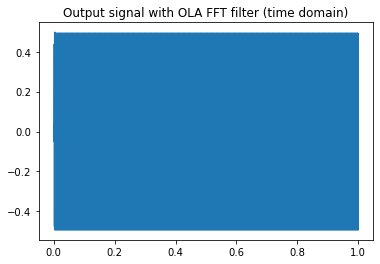

In [8]:
# Gráfica de la señal en el dominio del tiempo.

plt.plot(t,y_ola)
plt.title('Output signal with OLA FFT filter (time domain)')

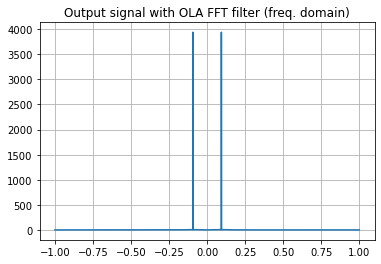

In [9]:
# Gráfica de la señal en el dominio de la frecuencia.

plt.plot(w , mag_y_ola_f)
plt.title('Output signal with OLA FFT filter (freq. domain)')
plt.grid(True)